# Handout #4: Classification with Logistic Regression



---



---



Content Authors:


*   Chris Malone Ph D, Professor of Data Science and Statistics, Winona State University; Email: cmalone@winona.edu
*   Collin Engstrom PhD, Assistant Professor of Computer Science, Winona State University; Email: collin.engstrom@winona.edu

Content in this handout was adapted from the following sources.
*    https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

* https://scikit-learn.org/1.5/modules/impute.html

* https://github.com/uci-ml-repo/ucimlrepo



---



---



## Libraries and Custom Functions

The following Python libraries will be used throughout this handout.

In [36]:
# Need to import TensorFlow library
import tensorflow as tf

# Also need Numpy and MatPlot libraries
import numpy as np
import matplotlib.pyplot as plt

# Sci-Kit Learn Libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# Seaborn - Plotting
import seaborn as sns

# Pandas - Data Management
import pandas as pd

print(tf.__version__)

2.17.1


The following are custom functions that will be used in this handout.

In [37]:
# Need a function that plots a confusion matrix for us
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold )
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [38]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.1,1.1])
  plt.ylim([0,1.1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

The **ucimlrepo** package can be used to easily import datasets from the UC Irvine Machine Learning Repository.  Source: [Github](https://github.com/uci-ml-repo/ucimlrepo)

In [39]:
pip install ucimlrepo



---



---



## Example: Heart Disease

<table width='100%' ><tr><td bgcolor='green'></td></tr></table>

Cardiovascular diseases (CVDs) are the number 1 cause of death globally.
 Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains features that can be used to predict presence of heart disease.

The original database contains 76 attributes, but all published experiments refer to using a subset of 14.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4.

<table>
  <tr>
    <td width='100%'>
      <ul>
        <li><strong>Target</strong>: num - indicates presence of heart disease</li><br>
        <ul>
          <li>0 - No presence of heart disease</li>
          <li>1 - Mild or some presence of heart disease</li>
          <li>2 - Moderate presence of heart disease</li>
          <li>3 - Severe presence of heart disease</li>
          <li>4 - Very severe presence of heart disease</li>
        </ul>
        <li><strong>Features</strong>:</li>
        <ul>
          <li>age - age of patient (years)</li>
          <li>sex - sex of patient (0 = Female, 1 = Male)</li>
          <li>cp - chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)</li>
          <li>trestbps - resting blood pressure on admission to the hospital ((mm Hg)</li>
          <li>chol - serum cholestoral (mg/dl)</li>
          <li>fbs - fasting block sugar > 120 mg/dl (0 = false, 1 = true) </li>
          <li>restecg - resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)</li>
          <li>thalach - maximum heart rate achieved</li>
          <li>exang: exercise induced angina (0 = No, 1 = Yes)</li>
          <li>oldpeak - ST depression induced by exercise relative to rest</li>
          <li>slope - the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)</li>
          <li>ca - number of major vessels (0-3) colored by flourosopy</li>
          <li>thal: thalassemia level (3 = normal; 6 = fixed defect; 7 = reversible defect)</li>
        </ul>
    </ul>
    </td>
</tr>
</table>

[Data - Local Copy](https://github.com/christophermalone/mayo_ml_workshop/blob/main/datasets/Heart_Disease.csv)

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1p1lS5NXdNodjo0RD85qaQUFIuqMq61bz" width='30%' height='30%'></img></p>

Image Source: [Link](https://medium.com/analytics-vidhya/heart-disease-prediction-using-knn-algorithm-be78f800e2a9)

<table width='100%' ><tr><td bgcolor='green'></td></tr></table>

The following code will read in the Heart Disease dataset directly from the UC Irvine Machine Learning Repository.  This dataset has id=45 on the UCI site.

In [40]:
from ucimlrepo import fetch_ucirepo

# fetch the heart disease dataset from UCI Repo
heart_disease = fetch_ucirepo(id=45)

The following will create a pandas data.frame (i.e. **X**) that contains the 13 features and the second data.frame that contains the target (i.e. y).

In [41]:
# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

print("The Features matrix:")
print(X)

print("The Target:")
print(y)

The Features matrix:
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   

The **ucimlrepo** package allows us to easily get meta information and a description of the variables for this dataset.

In [42]:
# Getting the metadata
print(heart_disease.metadata)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [43]:
# Getting variable information
print(heart_disease.variables)

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              



---



---



## Understanding Logistic Regression

### A Simple Example

 For our simple example, let's consider a prediction problem in which the target variable is whether or not a patient has Type 2 Diabetes.  The feature under consideration is Age of the patient.

<ul>
        <li><strong>Target</strong>: Type 2 Diabetes (0 = No, 1 = Yes)
        <li><strong>Feature Variable</strong>: Age</li>
    </ul>

Consider the following scatterplots and their corresponding data.

<p align="center">
<table align="center" bgcolor="white">
  <tr>
    <td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot I Graph</font> <br><img src="https://drive.google.com/uc?export=view&id=1Ri96uANkA6FQOsxVzS1DC3_PK8aV54DR"></img>
    </td>
<td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot I Data</font> <br><img src="https://drive.google.com/uc?export=view&id=1j9aWYlv06Nx0AZEA6QUznY6UCNmqzmLZ" width="50%",height="50%"></img>
</td>
  </tr>
</table>
</p>

<p align="center">
<table align="center" bgcolor="white">
  <tr>
    <td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot II Graph</font> <br><img src="https://drive.google.com/uc?export=view&id=1mirt2Zqbl69r-yd0Vhx-F9_oPCC7p2PD"></img>
    </td>
<td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot II Data</font> <br><img src="https://drive.google.com/uc?export=view&id=1J-pTvxwLPkV74bq5z6fZPTlAU4Me4AQY" width="50%",height="50%"></img>
</td>
  </tr>
</table>
</p>


Discussion Points for Plot I and Plot II

* The feature (Age) is on the x-axis and the target variable (Type 2 Diabetes) is on the y-axis.
* In Plot I, when Age is low (between 20 and 30), none of the patients have diabetes; when Age is high (between 70 and 80) all patients have diabetes. In this plot, the prediction for which class a patient belongs in (Yes or No) will have high accuracy.
* In Plot II, a similar pattern is present. When Age is between 20 and 40, none of the patients have diabetes and when Age is between 50 and 80 all the patients have diabetes.

Next, consider the following graphs.

<p align="center">
<table align="center" bgcolor="white">
  <tr>
    <td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot III</font> <br><img src="https://drive.google.com/uc?export=view&id=1FEdC5J6iOKseJ7MZvCJzAce2NGMeGeBG"></img>
    </td>
<td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot IV</font> <br><img src="https://drive.google.com/uc?export=view&id=1aYK8emMVSOK6mHXwErWjY7eYANAu7YIw" width="90%" height="90%"></img>
</td>
  </tr>
</table>
</p>

Discussion Points for Plot III and Plot IV

* Consider Plot III, the predictions for which class a patient belongs to will have high accuracy for Region A and for Region C.
* Consider Plot III, the predictions for which class a patient belongs to are less certain for Region B (between the ages of 40 and 60). Some of these patients in Region C have diabetes and others do not.
* Consider Region C in Plot III, patients between the ages of 40 to 50 appear to be less likely to have diabetes compared to a patient between the ages of 50 and 60.


* Plot IV includes a plot of the logistic curve. This function is determined from the data and is used to create a predicted probability of a patient having diabetes for each observation. This logistic model uses a patient's Age to make such predictions.
* The y-axis in Plot IV is the predicted probability of a patient having diabetes conditional on the patient's Age.
* From Plot IV, in Region A (when Age is low), the predicted probability of having diabetes is low (less than 30%); in Region C (when Age is high), the predicted probability of having diabetes is high (over 80%); the predicted probability of having diabetes is near 50% for a patient in Region B.
* A threshold value of 0.50 (or 50%) is shown on Plot IV. Any patient whose predicted probability of having diabetes that exceeds this threshold will be classified as having diabetes, i.e. will be predicted as Type 2 Diabetes = Yes.


Next, consider the following graphs in which the predicted probability that a patient has Type 2 Diabetes are compared for various curves.

<p align="center">
<table align="center" bgcolor="white">
  <tr>
    <td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot V</font> <br><img src="https://drive.google.com/uc?export=view&id=1yYpdZ6-Xz4fFEKoVtg8o1QMxg1fWYMp4"></img>
    </td>
<td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot VI</font> <br><img src="https://drive.google.com/uc?export=view&id=1I3IYbo-uX17KL74KdL0hKDagrGFc1HU8"></img>
</td>
  </tr>
</table>
</p>

Discussion Points for Plot V and Plot VI

* Two logistic curves are presented in Plot V. The predicted probability of a patient having diabetes increases more quickly for Curve B compared to Curve A. That is, the predicted probability of having diabetes is higher for Curve B than Curve A for patients who are younger (less than 40 years old). The predicted probability of having diabetes is similar for a patient who is over the Age of 70.
* In Plot VI, the predicted probability of having diabetes stays fairly consistent (around 20%) for Curve C between the Ages of 20 and 60. Between the Ages of 70 and 80, the predicted probability of having diabetes increases rapidly for Curve C.

Finally, consider the effect of adding Sex into a predictive logisitic model.

<p align="center">
<table align="center" bgcolor="white">
  <tr>
    <td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot VII</font> <br><img src="https://drive.google.com/uc?export=view&id=1NZ_7XOZvHgG-odwERuSpT8Q15NqNXn1g"></img>
    </td>
<td align="center" width="50%" bgcolor="white" valign="top"><font size="+2">Plot VIII</font> <br><img src="https://drive.google.com/uc?export=view&id=136gJfLGJ-1Qbv2WV-GD6sbRLmX7IFfFq"></img>
</td>
  </tr>
</table>
</p>


Discussion Points for Plot VII and Plot VIII

* Two logistic curves are presented in Plot VII. The predicted probability of a patient having diabetes for Males is higher than for Females. In this plot, the effect of Sex is consistent across Age.

* In Plot VIII, the influence of Sex on the predicted probability of one having diabetes various across Age. There is no effect of Sex when Age = 20, the effect increases to over 30% when Age = 50, then decreases to about 10% at Age = 85.



---



---



### The Logistic Regression Model

The process required to fit a logistic model varies between different software packages. For example, some software packages require that a numeric representation of the response variable be created before modeling. The standard numeric representation of a binary response variable is akin to the following for Type 2 Diabetes.

$$\begin{array}{rcl}
\mbox{Type2DiabetesValue} & = & \begin{array}{rl}  
\biggl\{ & \begin{array}{cl} 1 &  \mbox{Type 2 Diabetes = Yes} \\
0 &  \mbox{Type 2 Diabetes = No} \\
\end{array} \end{array}
\end{array}
$$

Another consideration that must be considered when dealing with fitting a logistic regression model is which binary outcome is the model predicting.  In the context of this example, one could predict the probability of Type 2 Diabetes = Yes or one could predict the probability of Type 2 Diabetes = No. The level of the response variable that is being modeled is commonly referred to as the <strong>"success"</strong> level.  So, if the goal is to make predictions for Type 2 Diabetes = Yes, a "success" would indicate that the patient has Type 2 Diabetes.

$$ \mbox{"success"} \rightarrow \mbox{Patient has diabetes}$$

Consider the following logistic regression model structure that will be used to predict $Type \space 2 \space Diabetes$ using $Age$ and $Sex$.  

$$ ln \left( \frac{\theta}{1-\theta} \right) = \beta_0 + \beta_1 * Age  + \beta_2 * Sex$$

where, $\theta = P(Type \space 2 \space Diabetes = Yes \space | \space Age, \space Sex)$, i.e. the probability that one has Type 2 Diabetes given their Age and Sex.

**Distribution of the Response Variable**

A logistic model is a type of generalized linear model (glm). The distribution of the response variable must be specified when fitting a generalized linear model. The target variable is binary which implies there are only two levels.  In this situation, a <strong>binomial</strong> distribution function is appropriate for the response.  A generalized linar model allows for other types of distributions to be specified for the response variable.

**Making Predictions**

After a logistic model has been fit, there are two steps required in order to obtain a prediction for the response.

<ul>
  <strong>Step #1</strong>: Obtain the predicted probability of success, i.e. $\theta$, for each observation

<br>

  $$ \theta  = \frac{e^{(\beta_{0} + \beta_{1} * Age + \beta_{2} * Sex)}}{1+e^{(\beta_{0} + \beta_{1} * Age + \beta_{2} * Sex)}}$$
  
<br>
<strong>Step #2</strong>: Use the predicted probability of success to classify the observation as either Type 2 Diabetes = Yes or Type 2 Diabetes = No; Classify as a success when the predicted probability is greater than or equal some threshold, typically a threshold value equal to 50% is intially considered</li>
  
  $$\begin{array}{rcl}
\mbox{Prediction for Type 2 Diabetes} & = & \begin{array}{rl}  
\biggl\{ & \begin{array}{cl} Yes & \theta \ge 0.50 \\ No &  \theta < 0.50 \end{array} \end{array}
\end{array}
$$

</ul>




---



---



## Recoding the Target Variable

A logistic regression model requires that the target be binary. For this dataset, the existing target variable has 5 levels (0, and 1-4).

In [44]:
print(y)

     num
0      0
1      2
2      1
3      0
4      0
..   ...
298    1
299    2
300    3
301    1
302    0

[303 rows x 1 columns]


The following graphs provides the distribution of the target variable.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1xPes5UnIWiughTqIbiklUbE443zDHVV2" width='50%' height='50%'></img></p>

In order to fit a logistic regression model, the target variable (y) will need to be recoded so that it is binary.  This will be done with the following specifications.

$$\begin{array}{rcl}
\mbox{y} & = & \begin{array}{rl}  
\biggl\{ & \begin{array}{cl} 1 &  \mbox{num levels 1-4 (i.e. present)} \\
0 &  \mbox{num level 0 (i.e. not present)} \\
\end{array} \end{array}
\end{array}
$$

The result of the recoding is shown visually here.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1EURjic2zeDAkOwfSe4iIc4WApQdsfMdg" width='50%' height='50%'></img></p>

Next, the following code can be used to recode the target variable to be binary.

In [45]:
# Recode / transform all non-zero labels to 1
y_binary = y.map(lambda x: np.where(x > 0, 1, 0))

In [46]:
#Check that recoding was successful
print(y_binary)

     num
0      0
1      1
2      1
3      0
4      0
..   ...
298    1
299    1
300    1
301    1
302    0

[303 rows x 1 columns]




---



---



## Balance of Target Variable

The **balance** of the outcomes for the target variable is something that should be considered when building a predictive model.  The opitimal class balance is 50/50.

In [47]:
# Find class balance
neg, pos = np.bincount(y_binary['num'])
total = neg + pos
print('Samples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples:
    Total: 303
    Positive: 139 (45.87% of total)



The balance of the target variable is good after the recoding has taken place.



---



---



## Pre-Processing of the Features

Recall the ucimlrepo package allowed us to easily read-in the $ \bf{X}$ matrix directly from the UC Irvine ML repository that contains the available features for the logisitic regression model.

In [48]:
#Get the number of rows and features
X.shape

(303, 13)

In [49]:
#Taking a look at the first few rows of the X matrix
X.head(5)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0




---



---



### Identification of Missingness

The X.describe method from the Pandas package allows one to easily summarize each of the variables in a data.frame.

In [50]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


**Comments**:  

* The features $ca$ and $thal$ have a reduced number of rows.

* The $ca$ feature has $4$ missing rows and the $thal$ feature has $2$ missing rows.

* Recall, $ca$ is the number of major vessels colored by flourosopy and $thal$ is the level of thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)

The following snipit of code will allow you to identify which rows are missing for which feature variables.

In [51]:
X[X.isna().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


If the rows containing the missingness are known, the following code provides the same output as above.

In [52]:
#Likewise, the following can be used if the row numbers of the missingness are known
X.iloc[[87,166,192,266,287,302]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0




---



---



### Methods of Simple Imputation

**Imputation** is the process of replacing missing data with substituted values.  There are various strategies that can be used to replace the missing data.  Some *simple* imputation methods include:

*  Mean - replace missing values of a feature using the mean or average value of that feature (appropriate for only numerical features)

* Median - replace missing values of a feature using the median value of that feature (appropriate for only numerical features)

* Most Frequent - replace the missing values of a feature using the most frequent value (appropriate for categorical or numeric
features)

* Constant - replace missing values of a feature with a specific value (appropriate for categorical or numerical features)


More sophisticated  methods of imputation exist.  Algorithms such as K-Nearest Neighbors (KNNImputer) and other multivariate imputators (e.g. IterativeImputer) are available in Python.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1iv_TAkHtoHrxTeG_W_NymVht-zQ7gai1" width='75%' height='75%'></img></p>

### Imputing the Missing Values of $ca$

The $ca$ feature is a count of the number of major vessels colored by flourosopy.  The distribution of $ca$ is shown here along with some basic summary statistics.   This distribution is of a count which is discrete, but is indeed numeric.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1Vw4F9yPRkyivy2_B7c5IeJI4zw59BjZr" width='50%' height='50%'></img></p>


The **Mean** method of imputation will be used for the $ca$ feature. Thus, missing value will be replaced by $0.672$

### Imputing the Missing Values of $thal$

The $thal$ feature identifies the thalassemia level which has levels 3 = normal, 6 = fixed defect, and 7 = reversible defect.  These measures are *not* naturally numeric - the values simply represent the type of defect.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1v1P8sW7IDTkMcJfgefA3uyq0OrUn2MRE" width='35%' height='35%'></img></p>


The **Most Frequent** method of imputation will be used for the $thal$ feature.  Thus, missing value will be replaced with $3$ (which represents Normal).



---



---



### Implementing Imputation

The following snipit of code uses **ColumnTransformer** (part of Sci-Kit Learn) to implement the desired imputation to the $ca$ and $thal$ features.  

**Note**: The columns which do not require imputation should be 'passed through' the ColumnTransformer so that they remain avaiable as features.

In [53]:
#Create the column tranformer for imputing missing rows
impute_column_tranformer = ColumnTransformer([
                                               ('imp_col1', SimpleImputer(missing_values=np.nan, strategy='mean'), ['ca']),
                                               ('imp_col2', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), ['thal'])
                                             ],
                                             remainder = 'passthrough')



Using the specified column transformer to impute the missing values in the feature data.frame.

In [54]:
#Impute the missing values of for ca and thal
#Notice: The imputated columns are listed first when returned; thus, rearrangement of col names is necessary
X_Imputed = pd.DataFrame(impute_column_tranformer.fit_transform(X),
                         columns=['ca','thal','age','sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']
                         )

Taking a look at the rows that had missingness to verify if the imputation methods worked.

In [55]:
X_Imputed.iloc[[87,166,192,266,287,302]]

,ca,thal,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
87,0.000000,3.0,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0
166,0.672241,3.0,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0
192,0.672241,7.0,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0
266,0.000000,3.0,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0
287,0.672241,7.0,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0
302,0.672241,3.0,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0




---



---



### Scaling the Features - MinMax and OneHotEncode

Let's take a look at the $\bf{X}$ matrix again to understand what features must be scaled.

In [56]:
X_Imputed.head(10)

,ca,thal,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.0,6.0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0
1,3.0,3.0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0
2,2.0,7.0,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0
3,0.0,3.0,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0
4,0.0,3.0,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0
5,0.0,3.0,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0
6,2.0,3.0,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0
7,0.0,3.0,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0
8,1.0,7.0,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0
9,0.0,7.0,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0


The following scaling will be done to the feature matrix $\bf{X}$.

* [Numeric] $ca$ - apply MinMax Scaler
* [Categorical] $thal$ - apply OneHotEncoder (3 levels will result in 2 variables)
* [Numeric] $age$ - apply MinMax Scaler
* [Categorical] $sex$ - none (already binary)
* [Categorical] $cp$ - apply OneHotEncoder (4 levels will result in 3 variables)
* [Numeric] $trestbps$ - apply MinMax Scaler
* [Numeric] $chol$ - apply MinMax Scaler
* [Categorical] $fbs$ - none (already binary)
* [Categorical] $restecg$ - apply OneHotEncoder (3 levels will result in 2 variables)
* [Numeric] $thalach$ - apply MinMax Scaler
* [Categorical] $exang$ - none (already binary)
* [Numeric] $oldpeak$ - apply MinMax Scaler
* [Categorical] $slope$ - apply OneHotEncoder (3 levels will result in 2 variables)

The following specifications for the **scaling** of the features are specified below for the ColumnTransformer.

In [57]:
#Note: Sex, fbs, and exang will do not need to be OneHotEncoded
transformers_list = [
                      ('encode', OneHotEncoder(dtype='int',drop='first'),['thal', 'cp', 'restecg', 'slope']),
                      ('scale', MinMaxScaler(), ['ca', 'age', 'trestbps', 'chol', 'thalach', 'oldpeak'])
                    ]

column_transformer = ColumnTransformer(transformers_list, remainder = 'passthrough')

The following snipit of code will apply the above columns transformer specifed above the the $\bf{X}_{Imputed}$ feature matrix.  Careful consideration is required when naming each of the columns from this scaling transformation.  The column order is specifed by the order in which the features are listed in the ColumnTransformer above.

In [58]:
#Apply the desired tranformation to the matrix of features
X_Imputed_Scaled = pd.DataFrame(column_transformer.fit_transform(X_Imputed),
                                columns=['thal_1','thal_2','cp_1', 'cp_2', 'cp_3','restecg_1', 'restecg_2', 'slope_1', 'slope_2', 'ca', 'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex', 'fbs', 'exang']
                               )

The final feature matrix that will be used to fit the logistic regression model.

In [59]:
X_Imputed_Scaled.head(10)

,thal_1,thal_2,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,ca,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.708333,0.481132,0.244292,0.603053,0.370968,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.000000,0.791667,0.622642,0.365297,0.282443,0.241935,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.666667,0.791667,0.245283,0.235160,0.442748,0.419355,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.166667,0.339623,0.283105,0.885496,0.564516,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.250000,0.339623,0.178082,0.770992,0.225806,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.562500,0.245283,0.251142,0.816794,0.129032,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.666667,0.687500,0.433962,0.324201,0.679389,0.580645,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.583333,0.245283,0.520548,0.702290,0.096774,0.0,0.0,1.0
8,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.333333,0.708333,0.339623,0.292237,0.580153,0.225806,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.500000,0.433962,0.175799,0.641221,0.500000,1.0,1.0,1.0


The binary target variable that will be used in the fitting of the logistic regression model.

In [60]:
y_binary[0:10]

,num
0,0
1,1
2,1
3,0
4,0
5,0
6,1
7,0
8,1
9,1




---



---



## Split-Sample Validation

A split-sample validation approach will be implemented here when fitting our logistic regression model.  The split-sample will use $70\%$ of the samples for the training set and $30\%$ of the samples for the test set, i.e. a $70:30$ specification.

In [61]:
# Break into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Imputed_Scaled,y_binary,
                                   test_size=0.3,
                                   random_state=0,
                                   shuffle=True)

After the OneHot Encoding has been applied to the categorical features, there are a total of $18$ columns in the feature matrix.

In [62]:
# determine the number of input features
n_features = X_train.shape[1]
print(n_features)

18




---



---



## Fitting the Logistic Regression Model

The **LogisticRegression** function will be from the sklearn.linear_model package will be used to fit the logistic regression model.  The following specificiations will be used for our logisitic regression model.

* penalty = 'l2' // a L-2 loss function will be used (i.e. squared-error loss)
* solver = 'liblinear' // Library for Large Linear Classification (liblinear) focuses on solving large-scale linear classification tasks, including logistic regression and linear support vector machines (SVMs) with L1 and L2.  Good choice for small datasets; whereas, ‘sag’ and ‘saga’ are faster for large ones
* max_iter = 100 // maximum number of iterations that will be used for the solver to converge

Source: [Scikit Learn Logisitic Regression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [63]:
# Provide model specifications
logistic_model = LogisticRegression(penalty='l2',
                           solver='liblinear',
                           max_iter=100
                          )

Next, fitting the logistic regression model to our training set.

In [64]:
#Fitting the logisitc regression model
#Note:  the ravel() method converts flattens the array -- simply preventing a warning from being thrown

logistic_model.fit(X_train, y_train.values.ravel())

LogisticRegression(solver='liblinear')

The .predict\_proba() function will return the predicted probabilities for the target variable.  Here, predicted probabilities are obtained for the test set.

In [65]:
# Get predictions for the binary target variable
y_pred = logistic_model.predict_proba(X_test)

print(pd.DataFrame(y_pred))

           0         1
0   0.960999  0.039001
1   0.603536  0.396464
2   0.170010  0.829990
3   0.633592  0.366408
4   0.720984  0.279016
..       ...       ...
86  0.958572  0.041428
87  0.048843  0.951157
88  0.039921  0.960079
89  0.018127  0.981873
90  0.853440  0.146560

[91 rows x 2 columns]


Realize, only one set of predicted probabilities are needed as the target variable in binary.  Here, the predicted probabilities will be retained for the positive cases (i.e. 1).

In [66]:
# Get predictions for the positive target variable (i.e. probability of 1)
y_pred = logistic_model.predict_proba(X_test)[:, 1]

print(pd.DataFrame(y_pred))

           0
0   0.039001
1   0.396464
2   0.829990
3   0.366408
4   0.279016
..       ...
86  0.041428
87  0.951157
88  0.960079
89  0.981873
90  0.146560

[91 rows x 1 columns]




---



---



## Model Quality - Area Under Curve

The following code can be used to create a confusion matrix. This code uses the custom plot_cm() function provided above.  

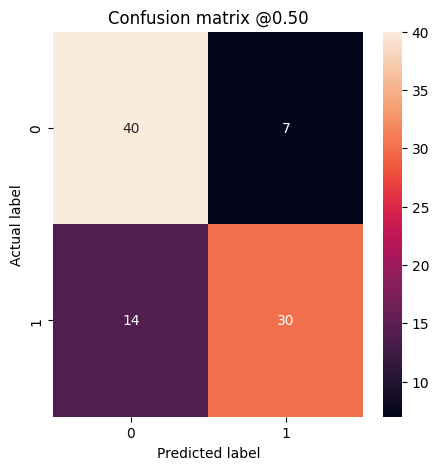

In [67]:
#Confusion Matrix
plot_cm(y_test, y_pred, 0.5)

The following code can be be used to compute $Area \, Under \, ROC$.  Model performance metrics should be computed on the *test* set.

In [71]:
# evaluate the model using AUC
auc_test = roc_auc_score(y_test, y_pred)

print('Area Under Curve (Test set): %.3f' % auc_test)

Area Under Curve (Test set): 0.875


The $ROC$ plot is provided below.

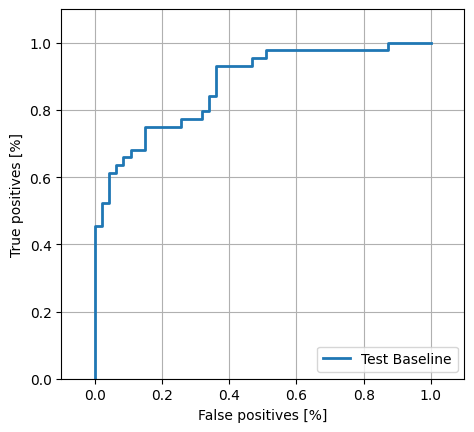

In [69]:
# Do an ROC curve
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Test Baseline", y_test, y_pred, color=colors[0])
plt.legend(loc='lower right');



---



---



## Variable Importance

One may gain valueable information when considering the coefficients from the logisitic regression model.  The following snipit of code allows us to compare the magnitude of each of the regression coefficients.

**Note**:  A direct comparison of the coefficients should only be done when the features have properly scaled.

In [72]:
# Getting the coefficients from the logistic regression model
coefficients = logistic_model.coef_[0]

#Puttin the coefficients into a data.frame
feature_importance = pd.DataFrame({
                                   'Feature': X_Imputed_Scaled.columns,
                                   'Coefficient': coefficients
                                  })
#Sort the data.frame in order of magnitude of coefficients
feature_importance.sort_values(by = 'Coefficient', key=abs, ascending=False)

,Feature,Coefficient
9,ca,1.888407
13,thalach,-1.669599
1,thal_2,1.408675
14,oldpeak,1.060542
7,slope_1,1.055003
17,exang,0.995532
11,trestbps,0.719939
3,cp_2,-0.673371
4,cp_3,0.660567
8,slope_2,0.474054


The interpretation of the estimated model parameter for, say $ca$, is as follows.  

Suppose the $ca = 1$ for person A and the $ca = 2$ for person B (i.e. a 1-unit change in $ca$ between person A and person B). Assume all other features are held constant between Person A and Person B.

$$
\begin{array}{rcl}
\mbox{Odds Ratio for Heart Disease} & = &  e^{\hat{\beta}_{ca} * \Delta} \\
                               & = &  e^{1.88 * 1} \\
                               & = & 6.55
\end{array}
$$

**Interpretation of Coefficient for ca**: The odds of the presence of heart disease is 6.55 times higher for Person B compared to Person A.  This is a considerable increase in the odds of heart disease.

**Interpretation of Coefficient for Sex**:  A male ($Sex = 1)$ has $e^{0.33} = 1.39$ times higher odds of the presence of heart disease compared against a female ($Sex = 0$).



---



---

End of Document